<a href="https://colab.research.google.com/github/Stability-AI/model-demo-notebooks/blob/main/jsdxl_dreambooth_lora.ipynb\" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning JSDXL with diffusers 🧨
In this notebook, we show how to fine-tune [Japanese Stable Diffusion XL](https://huggingface.co/stabilityai/japanese-stable-diffusion-xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

- Blog: https://ja.stability.ai/blog/japanese-stable-diffusion-xl
- Twitter: https://twitter.com/StabilityAI_JP
- Discord: https://discord.com/invite/StableJP


#### Reference
- [SDXL Fine-tuning example from HuggingFace](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/SDXL_DreamBooth_LoRA_.ipynb)

## Setup 🪓

In [ ]:
# Check the GPU
!nvidia-smi

Download necessary scripts

In [ ]:
!wget https://gist.githubusercontent.com/mkshing/4466428a14ecf31dcfc1bf45057c4b95/raw/57c48c8570fa2132c088f8b2029428db72ee3d46/requirements.txt
!wget https://gist.githubusercontent.com/mkshing/4466428a14ecf31dcfc1bf45057c4b95/raw/bc6e0093ce5e73e87dffe9e9ce1866724aecbb8e/train_dreambooth_lora_jsdxl.py

In [ ]:
# Install dependencies.
!pip install -r requirements.txt

## Dataset 🐶

Let's download some example images:

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Preview the images:

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

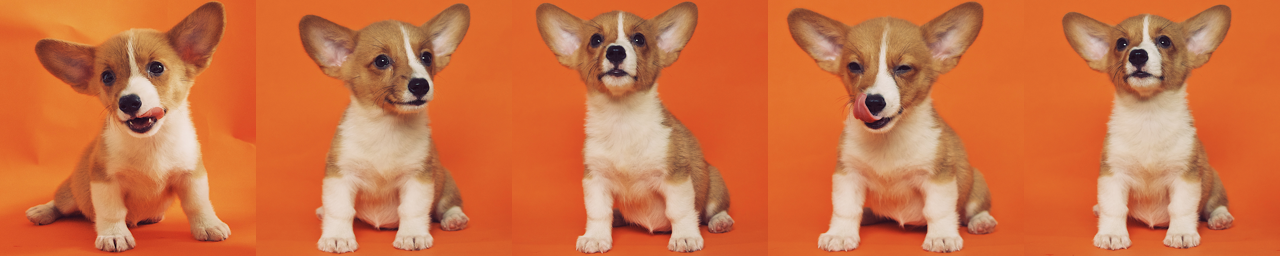

In [16]:
import glob

imgs = [Image.open(path) for path in glob.glob("./dog/*.jpeg")]
image_grid(imgs, 1, 5)

## Prep for training 💻

Initialize `accelerate`:

In [ ]:
!accelerate config default

Make sure to log into [your Hugging Face account](https://huggingface.co/) and pass [your access token](https://huggingface.co/docs/hub/security-tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [ ]:
!huggingface-cli login

## Train! 🔬

Alright let's launch a training.
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* Memory-efficient attention (`--enable_xformers_memory_efficient_attention`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)
* ⭐ Use `輻` for JSDXL intead of `sks`


In [ ]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_jsdxl.py \
  --pretrained_model_name_or_path="stabilityai/japanese-stable-diffusion-xl" \
  --instance_data_dir="dog" \
  --output_dir="lora-trained-jsdxl" \
  --mixed_precision="fp16" \
  --instance_prompt="輻の犬" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --enable_xformers_memory_efficient_attention \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0" \
  --push_to_hub


Let's generate some images with it!

## Inference 🐕

In [17]:
from diffusers import DiffusionPipeline
import torch

lora_name_or_path = "mkshing/lora-trained-jsdxl" #@param {"type": "string"}
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/japanese-stable-diffusion-xl",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
pipe.load_lora_weights(lora_name_or_path)

_ = pipe.to("cuda")

Keyword arguments {'trust_remote_code': True} are not expected by JapaneseStableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

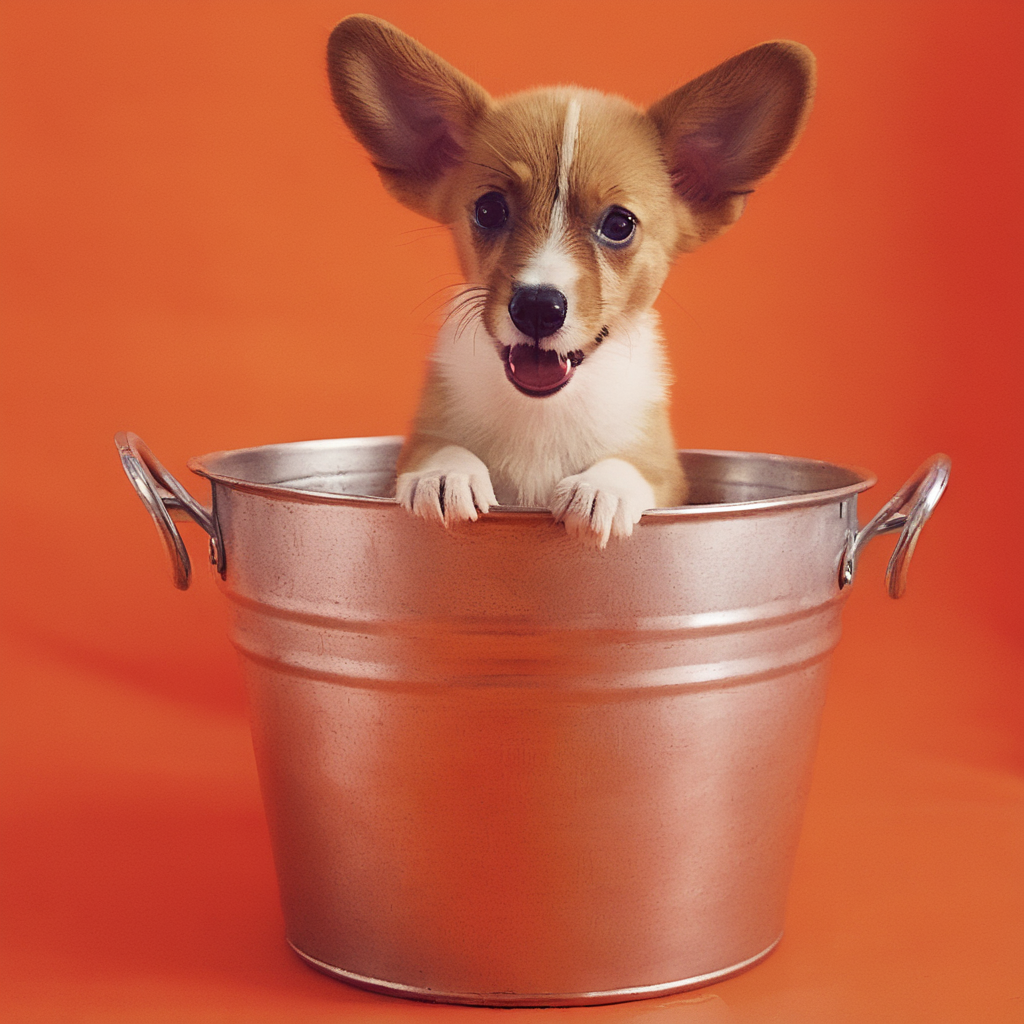

In [25]:
prompt = "バケツの中に入っている輻の犬"

image = pipe(prompt=prompt).images[0]
image